# Import Packages

In [1]:
!pip install -U sentence-transformers
!pip install umap-learn
!pip install hdbscan

     |████████████████████████████████| 64 kB 572 kB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-py3-none-any.whl size=101031 sha256=bbb33a8a767f46b85a78c9766e32b0e955e52d2111e460d4731d5f669a25bf3c
  Stored in directory: /home/elbaz/.cache/pip/wheels/3f/7e/94/11a2db6c28b6ff552919cd73029d113dfba333754d0fb82667
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 0.3.8
    Uninstalling sentence-transformers-0.3.8:
      Successfully uninstalled sentence-transformers-0.3.8
     |████████████████████████████████| 4.7 MB 721 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2404960 sha256=01f934bd3f9c148079eec5689906a08358af5e994bde5c50421efd7555b6903e
  Stored in directory: /ho

In [2]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
import string
import re

In [3]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

# Import Data and Preprocessing

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
# import data 20news from sklearn 
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'),
                                      random_state=42)
# transform into dataframe the text and the targets
df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
df.columns = ['text', 'target']
# transform into dataframe the categories
targets = pd.DataFrame( newsgroups_train.target_names)
targets.columns=['category']
# merge the both
data_train = pd.merge(df, targets, left_on='target', right_index=True)
# keep only the text and the titlcategoryes associated
data_train.reset_index(inplace=True)
data_train.drop(['index', 'target'], axis=1, inplace=True)
# modify the dataframe for getting a sub categories (5 levels of categories)
data_train.category = data_train.category.apply(lambda t: t.split('.'))
data_train.category = data_train.category.apply(lambda t: t+['none' for i in range(5-len(t))])
s = data_train.category
dd = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
dd.columns = ['sub_cat_0', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4']
data_train = pd.concat([data_train, dd], axis=1)

# import data 20news from sklearn 
newsgroups_train = fetch_20newsgroups(subset='test', 
                                      remove=('headers', 'footers', 'quotes'),
                                      random_state=42)
# transform into dataframe the text and the targets
df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
df.columns = ['text', 'target']
# transform into dataframe the categories
targets = pd.DataFrame( newsgroups_train.target_names)
targets.columns=['category']
# merge the both
data_test = pd.merge(df, targets, left_on='target', right_index=True)
# keep only the text and the titlcategoryes associated
data_test.reset_index(inplace=True)
data_test.drop(['index', 'target'], axis=1, inplace=True)
# modify the dataframe for getting a sub categories (5 levels of categories)
data_test.category = data_test.category.apply(lambda t: t.split('.'))
data_test.category = data_test.category.apply(lambda t: t+['none' for i in range(5-len(t))])
s = data_test.category

dd = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
dd.columns = ['sub_cat_0', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4']
data_test = pd.concat([data_test, dd], axis=1)

In [6]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
          #  gsp.strip_numeric,
          #  gsp.remove_stopwords, 
           gsp.strip_short, 
          #  gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [7]:
data_train.text = data_train.text.apply(lambda t: clean_text(t))

In [8]:
data_train['text_size'] = data_train.text.apply(lambda t: len(t.split(' ')))

In [9]:
data_train = data_train[data_train.text_size>1].reset_index()
data_train.drop(['index'], axis=1, inplace=True)

In [10]:
data_train = data_train.sample(frac=1.0).reset_index()
data_train.drop(['index'], axis=1, inplace=True)

# EDA

## Sub Cat 0 - Pie graph

We want to observe the distribution of the principale category

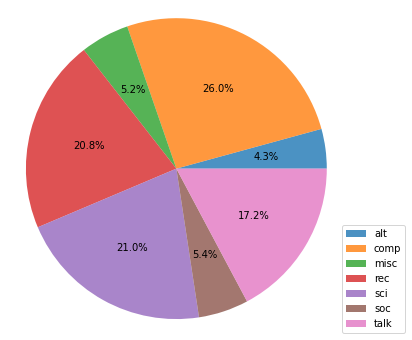

In [ ]:
figure = plt.figure(figsize=(6, 6))

sc0, sizes = np.unique(data_train.sub_cat_0, return_counts=True)
#sc0_names = [data_train.sub_cat_0.values[i] for i in sc0]

patches, _, _ = plt.pie(sizes, autopct='%1.1f%%', wedgeprops={'alpha': 0.8})

plt.legend(patches, sc0, loc=(1, 0.0))

plt.axis('equal')
plt.show()

We notice that categories COMP, SCI, REC and TALK are +/- equally represented. Whereas categories MISC, ALT, SOC are slighlty represented.

We can assume that some statistics of the documents are different according to the category.

## Zipf Law

In [ ]:
# https://en.wikipedia.org/wiki/Zipf%27s_law

def zipfs_law(texts,
               low_outlier_percentile_bound=1,
               upper_outlier_percentile_bound=99):

    counter = Counter(' '.join(texts).split())
    frequencies = [freq for word, freq in counter.most_common()]
    low_outlier_bound = np.percentile(frequencies, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(frequencies, upper_outlier_percentile_bound)
    frequencies = [freq for freq in frequencies if freq > low_outlier_bound and freq <= upper_outlier_bound]
    ranks = range(1, len(frequencies) + 1)

    return ranks , frequencies

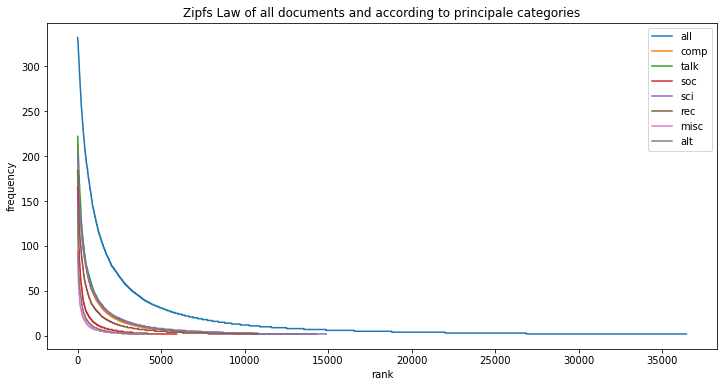

In [ ]:
plt.figure(figsize=(12,6))
for cat in ['all']+data_train.sub_cat_0.unique().tolist():
  if cat=='all':
    all_doc = data_train.text.values.tolist()
    r_all, f_all = zipfs_law(all_doc)
    plt.plot(r_all, f_all, label='all')
  else:
    sc0_doc = data_train[data_train.sub_cat_0==cat].text.values.tolist()
    r_cat, f_cat = zipfs_law(sc0_doc)
    plt.plot(r_cat, f_cat, label=cat)
plt.legend()
plt.title("Zipfs Law of all documents and according to principale categories")
plt.xlabel('rank')
plt.ylabel('frequency')
plt.show()

## Heaps Law

In [ ]:
def heaps_law(texts):
  lengths = [len(t.split()) for t in texts]
  num_uniques = [len(set(t.split())) for t in texts]
  return lengths, num_uniques

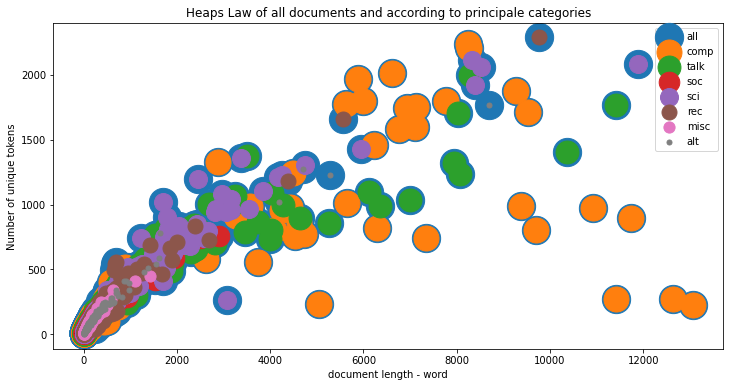

In [ ]:
plt.figure(figsize=(12,6))

for i, cat in enumerate(['all']+data_train.sub_cat_0.unique().tolist()):
  if cat=='all':
    all_doc = data_train.text.values.tolist()
    r_all, f_all = heaps_law(all_doc)
    plt.scatter(r_all, f_all, label='all', s=800 - i*100)
  else:
    sc0_doc = data_train[data_train.sub_cat_0==cat].text.values.tolist()
    r_cat, f_cat = heaps_law(sc0_doc)
    plt.scatter(r_cat, f_cat, label=cat, s=800-(i+0.75)*100)
plt.legend()
plt.title("Heaps Law of all documents and according to principale categories")
plt.xlabel('document length - word')
plt.ylabel('Number of unique tokens')
plt.show()

## Histogram of documents lengths

In [ ]:
def lengths_histogram(texts,
                      low_outlier_percentile_bound=1,
                      upper_outlier_percentile_bound=99):
  
    lengths = [len(t.split()) for t in texts]
    low_outlier_bound = np.percentile(lengths, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(lengths, upper_outlier_percentile_bound)
    lengths = [l for l in lengths if l > low_outlier_bound and l <= upper_outlier_bound]
    return lengths

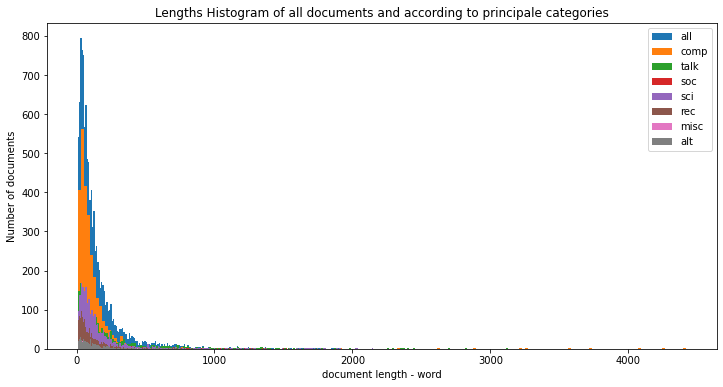

In [ ]:
plt.figure(figsize=(12,6))

for i, cat in enumerate(['all']+data_train.sub_cat_0.unique().tolist()):
  if cat=='all':
    all_doc = data_train.text.values.tolist()
    r_all = lengths_histogram(all_doc)
    plt.hist(r_all, label='all', bins=200)
  else:
    sc0_doc = data_train[data_train.sub_cat_0==cat].text.values.tolist()
    r_cat= lengths_histogram(sc0_doc)
    plt.hist(r_cat, label=cat, bins=200)
plt.legend()
plt.title("Lengths Histogram of all documents and according to principale categories")
plt.xlabel('document length - word')
plt.ylabel('Number of documents')
plt.show()

## Relation between each sub categories

In [ ]:
for cat in ['sub_cat_0', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4']:
  s = data_train[cat].value_counts()
  plt.bar(s.index, s.values/s.sum())
  plt.xticks(rotation=45)
  plt.xlabel(cat)
  plt.ylabel('Probability')
  plt.title(r'Histogram of '+ cat)
  plt.show()

In [ ]:
col = ['sub_cat_0','sub_cat_1','sub_cat_2','sub_cat_3','sub_cat_4']
df_cat = data_train[col]
targets = []
for cat in col:
  targets = targets + [t for t in df_cat[cat].unique().tolist()]
tragets = list(set(targets))

n = len(targets)
mat_corr_cat = np.zeros((n, n))
dict_cat = {}
for row in df_cat.itertuples():
  print(row.sub_cat_0)
  break

In [ ]:
df_cat.groupby(df_cat.columns.tolist()).size().reset_index()

In [ ]:
(pd.crosstab(df_cat.sub_cat_0, df_cat.sub_cat_1).T/df_cat.groupby('sub_cat_0').size().values).T

In [ ]:




from sklearn.mixture import GaussianMixture as GMM

from sklearn.cluster import SpectralClustering


from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, SpectralEmbedding
from umap import UMAP

# Corpus extraction

In [11]:
corpus = data_train.text.values.tolist()

# Topic extraction with NMF and LDA

In [ ]:
from time import time
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
n_samples = 2000
n_features = 1000
n_components = 7
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.



In [ ]:
random.shuffle(corpus)
corpus_samples = corpus[:n_samples]

In [ ]:
# Use tf-idf features
print("Extracting tf-idf features...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                   min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(corpus_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features.
print("Extracting tf ...")
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(corpus_samples)
print("done in %0.3fs." % (time() - t0))
print()


Extracting tf-idf features...
done in 0.277s.
Extracting tf ...
done in 0.254s.



In [ ]:

# Fit the NMF model with Frobenius norm and tfidf
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model with Kullback-Leiber and tfidf
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.181s.

Topics in NMF model (Frobenius norm):
Topic #0: just don people like think time good ve right say
Topic #1: windows thanks file card dos mail problem use window software
Topic #2: god jesus bible christ christians faith son believe paul man
Topic #3: team game games season year players player hockey play detroit
Topic #4: does know mean thanks don info just help hi anybody
Topic #5: key chip encryption data escrow clipper keys phone use government
Topic #6: edu soon university cs com internet address email mac pub

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.821s.

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: think time good make people right way don probably really
Topic #1: windows use thanks card file using problem drive need software
Topic #2: god peop

In [ ]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model with tf:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

print("Fitting LDA models with tfidf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model with tfidf:")
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 2.937s.

Topics in LDA model with tf:
Topic #0: file output use windows thanks does like using know time
Topic #1: people know don just god does say time think like
Topic #2: ax max b8f g9v 1d9 pl 0t wm 145 34u
Topic #3: 25 10 14 12 11 16 20 15 13 18
Topic #4: just don year like good going think new people know
Topic #5: edu entry com program file send entries use rules key
Topic #6: mr gun file states president control vs crime guns united

Fitting LDA models with tfidf features, n_samples=2000 and n_features=1000...
done in 1.390s.

Topics in LDA model with tfidf:
Topic #0: mike ground linked required allocation title says cross effect unit
Topic #1: just don people know think like time good does god
Topic #2: col hp winners george manager let isn com thing dave
Topic #3: 1993 ax april 20 00 30 table march general col
Topic #4: card thanks drive sale apple mail monitor scsi drivers looking
Topic #5: wi

# Vector Embedding with SBERT

In [12]:
from sentence_transformers import SentenceTransformer, util

/home/elbaz/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/elbaz/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/elbaz/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/elbaz/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [13]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

I1202 13:05:49.312990 139916957488960 SentenceTransformer.py:38] Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
I1202 13:05:49.314472 139916957488960 SentenceTransformer.py:42] Did not find folder bert-base-nli-mean-tokens
I1202 13:05:49.315173 139916957488960 SentenceTransformer.py:48] Try to download model from server: https://sbert.net/models/bert-base-nli-mean-tokens.zip
I1202 13:05:49.316404 139916957488960 SentenceTransformer.py:99] Load SentenceTransformer from folder: /home/elbaz/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens
I1202 13:05:52.980720 139916957488960 SentenceTransformer.py:123] Use pytorch device: cpu


In [14]:
corpus_embeddings = embedder.encode(corpus)

## Similarity Matrix

In [15]:
#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.pytorch_cos_sim(corpus_embeddings, corpus_embeddings)
cosine_scores = cosine_scores.numpy()

# Apply clustering on full vectors

In [16]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score

## KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

In [ ]:
corpus_embeddings_norm = Normalizer().fit_transform(corpus_embeddings)

### Euclidean distance

In [ ]:
num_clusters = 7

km = KMeans(n_clusters=num_clusters)

km.fit(corpus_embeddings)

clusters = km.labels_.tolist()

data_train['km_clusters'] = clusters

ari = adjusted_rand_score(data_train.sub_cat_0, data_train.km_clusters)

nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.km_clusters)

vm = v_measure_score(data_train.sub_cat_0, data_train.km_clusters)

print(ari, nmi, vm)

0.13939633735453727 0.18308542330871502 0.18308542330871502


### Cosinus distance

In [ ]:
num_clusters = 7

km = KMeans(n_clusters=num_clusters)

km.fit(corpus_embeddings_norm)

clusters = km.labels_.tolist()

data_train['km_norm_clusters'] = clusters

ari = adjusted_rand_score(data_train.sub_cat_0, data_train.km_norm_clusters)

nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.km_norm_clusters)

vm = v_measure_score(data_train.sub_cat_0, data_train.km_norm_clusters)

print(ari, nmi, vm)

0.1414331531038984 0.1853549253809701 0.1853549253809701


## Agglomerative clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

### Precomputed and complete linkage

In [ ]:
for X in [corpus_embeddings, corpus_embeddings_norm]:
  agg = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='complete')

  cosine_scores = util.pytorch_cos_sim(X, X)
  cosine_scores = cosine_scores.numpy()

  agg = agg.fit(1 - cosine_scores)

  data_train['agg_clusters'] = agg.labels_

  ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)

  nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

  print(ari, nmi)

0.047436413463331016 0.06428626820347437
0.047436413463331016 0.06428626820347437


### Euclidean and Ward linkage

In [ ]:
for X in [corpus_embeddings, corpus_embeddings_norm]:
  agg = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')

  agg = agg.fit(X)

  data_train['agg_clusters'] = agg.labels_

  ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)

  nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

  print(ari, nmi)

0.17053223515538246 0.2586089473384731
0.15435504392818641 0.21730469789272125


### Cosinus and Complete Linkage

In [ ]:
for X in [corpus_embeddings, corpus_embeddings_norm]:
  agg = AgglomerativeClustering(n_clusters=7, affinity='cosine', linkage='complete')

  agg = agg.fit(corpus_embeddings)

  data_train['agg_clusters'] = agg.labels_

  ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)

  nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

  print(ari, nmi)

0.047436413463331016 0.06428626820347437
0.047436413463331016 0.06428626820347437


# DimRed Solutions

In [18]:
import umap
from sklearn.decomposition import PCA

## UMAP

### Distance Matrix - precomputed

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


2


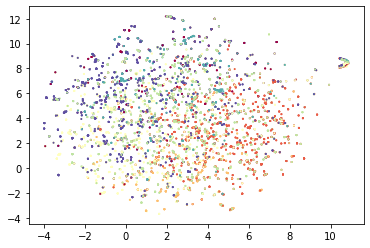

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


5


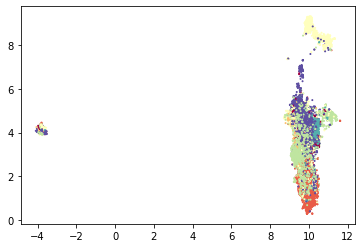

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


10


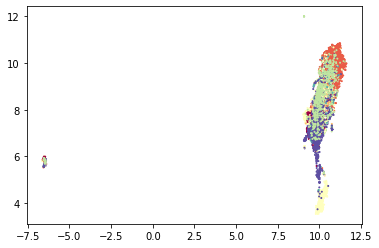

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


30


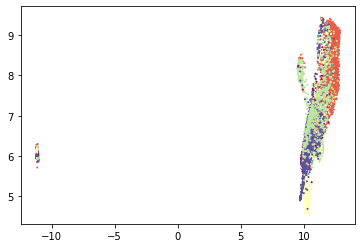

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


50


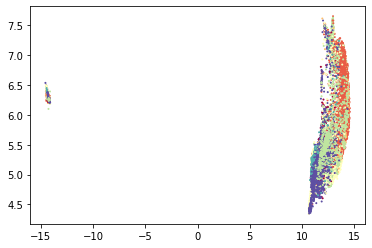

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


100


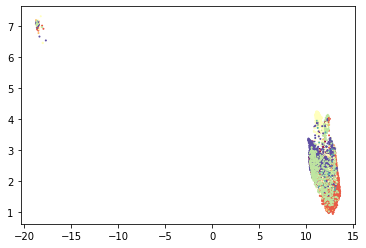

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


200


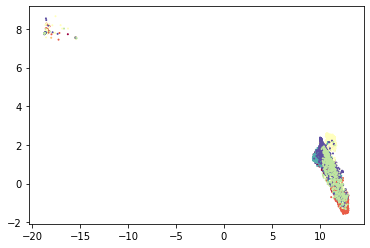

In [ ]:
for nn in [2,5,10,30,50,100,200]:
  dr_umap = umap.UMAP(n_components=5, metric='precomputed', n_neighbors=nn, min_dist=0.0)
  corpus_embeddings_umap = dr_umap.fit_transform(1-cosine_scores)
  print(nn)
  a = data_train["sub_cat_0"].astype('category')
  plt.scatter(corpus_embeddings_umap[:, 0], corpus_embeddings_umap[:, 1], c=a.cat.codes,s=1, cmap='Spectral')
  plt.show()

## PCA + UMAP Application

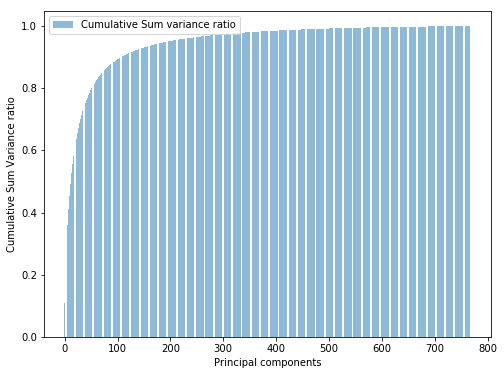

In [19]:
pca = PCA()
pca.fit(corpus_embeddings)
pca_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.5, align='center', label='Cumulative Sum variance ratio')
plt.legend()
plt.ylabel('Cumulative Sum Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [20]:
np.where(pca_variance>=0.95)[0].min()

194

In [21]:
pca = PCA(200)
X_pca = pca.fit_transform(corpus_embeddings)

In [ ]:
dr_umap = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=100, min_dist=0.0)
corpus_embeddings_umap = dr_umap.fit_transform(X_pca)


In [ ]:
a = data_train["sub_cat_0"].astype('category')
plt.scatter(corpus_embeddings_umap[:, 0], corpus_embeddings_umap[:, 1], c=a.cat.codes,s=1, cmap='Spectral')
plt.show()


In [ ]:
num_clusters = 7

km = KMeans(n_clusters=num_clusters)

km.fit(corpus_embeddings_umap)

clusters = km.labels_.tolist()

data_train['km_clusters'] = clusters

ari = adjusted_rand_score(data_train.sub_cat_0, data_train.km_clusters)

nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.km_clusters)

vm = v_measure_score(data_train.sub_cat_0, data_train.km_clusters)

print(ari, nmi, vm)

0.2582628844987543 0.36245853337520456 0.36245853337520456


In [ ]:
agg = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')

agg = agg.fit(corpus_embeddings_umap)

data_train['agg_clusters'] = agg.labels_

ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)

nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

print(ari, nmi)

0.24125574087541612 0.32605195498903866


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
d = {}
for cat in data_train.sub_cat_0.unique():
  d[cat] = {}
  tj = data_train[(data_train.sub_cat_0==cat)].shape[0]
  for c in data_train.agg_clusters.unique():
    ti = data_train[(data_train.agg_clusters==c)].shape[0]
    cij = data_train[(data_train.sub_cat_0==cat)&(data_train.agg_clusters==c)].shape[0]
    pi = cij/ti
    ri = cij/tj
    try:
      d[cat][str(c)] = 2*pi*ri/(pi+ri)
    except:
      d[cat][str(c)] = 0

In [ ]:
pd.DataFrame(d).T

,2,0,5,6,1,3,4
comp,0.493074,0.004997,0.562323,0.046983,0.043332,0.000000,0.006796
talk,0.044895,0.593484,0.012454,0.198895,0.102984,0.006456,0.007930
sci,0.101670,0.073040,0.224185,0.272311,0.265811,0.003118,0.263295
rec,0.072099,0.064321,0.049440,0.071963,0.409656,0.555102,0.003000
alt,0.015219,0.193113,0.004114,0.155609,0.032939,0.001461,0.004700
misc,0.137489,0.009573,0.177851,0.013590,0.090468,0.004062,0.006257
soc,0.013577,0.323810,0.005263,0.055025,0.029707,0.001340,0.004107


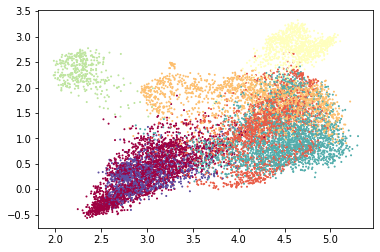

In [ ]:
# a = data_train["sub_cat_0"].astype('category')
plt.scatter(corpus_embeddings_umap[:, 0], corpus_embeddings_umap[:, 1], c=data_train.agg_clusters,s=1, cmap='Spectral')
plt.show()